In [71]:
import os
from datetime import datetime

use_simulated_data = True
display_log_branch_lengths = True

if use_simulated_data:
    latest_result_search_dir = "results/cellphy_simulated_data"
    original_phy_file = "data/cellphy_simulated_set.phy"
else:
    latest_result_search_dir = "results/cellphy_toy_data"
    original_phy_file = "data/cellphy_toy_set.phy"


def find_latest_result():
    # Initialize variables to keep track of the latest file and its creation date
    latest_file = None
    latest_date = datetime.min

    # Walk through the directory tree and search for the file
    for dirpath, dirnames, filenames in os.walk(latest_result_search_dir):
        for filename in filenames:
            if filename == "results.p":
                file_path = os.path.join(dirpath, filename)
                creation_date = datetime.fromtimestamp(os.path.getctime(file_path))
                if creation_date > latest_date:
                    latest_file = file_path
                    latest_date = creation_date

    if latest_file is None:
        raise FileNotFoundError("No results file found in the directory tree.")

    return latest_file


result_path = find_latest_result()
print(result_path)

results/cellphy_simulated_data/False/300/2023-11-27-220922/results.p


In [72]:
import pickle
import numpy as np
import json
from abc import ABC, abstractmethod

In [73]:
with open(original_phy_file, "r") as f:
    phy_file_raw = f.readlines()

labels = [line.split(" ")[0] for line in phy_file_raw[1:]]
labels += ["Dummy"]

In [74]:
with open(result_path, "rb") as f:
    data = pickle.load(f)

data["best_jump_chain"].shape

(300, 231)

In [75]:
best_arg_sort = np.argsort(data["best_log_lik"])[::-1]
best_jc_list = data["best_jump_chain"]
best_left_branches_list = np.transpose(data["left_branches"][data["best_epoch"]])
best_right_branches_list = np.transpose(data["right_branches"][data["best_epoch"]])

In [76]:
class Node(ABC):
    @abstractmethod
    def has(self, value: str) -> bool:
        pass

    @abstractmethod
    def find(self, value: str) -> "Node | None":
        pass

    @abstractmethod
    def flat_values(self) -> set[str]:
        pass


class Leaf(Node):
    def __init__(self, value):
        self.value = value
        self.parent = None

    def has(self, value):
        return self.value == value

    def find(self, value):
        if self.value == value:
            return self
        else:
            return None

    def flat_values(self):
        return set([self.value])

    def __str__(self):
        return str(self.value)


class Inner(Node):
    def __init__(self, left, right, left_len, right_len):
        self.left = left
        self.right = right

        self.left_len = left_len
        self.right_len = right_len

        left.parent = self
        left.parent_len = left_len
        right.parent = self
        right.parent_len = right_len

        self.parent = None
        self.parent_len = None

    def has(self, value):
        return self.left.has(value) or self.right.has(value)

    def find(self, value):
        return self.left.find(value) or self.right.find(value)

    def flat_values(self):
        return self.left.flat_values() | self.right.flat_values()

    def __str__(self):
        left_len = (
            np.log(self.left_len + 1) if display_log_branch_lengths else self.left_len
        )
        right_len = (
            np.log(self.right_len + 1) if display_log_branch_lengths else self.right_len
        )
        return f"({self.left}:{left_len},{self.right}:{right_len})"


def build_tree(jc, left_branches, right_branches) -> Node:
    """Returns the Newick representation of the tree represented by the jump chain"""

    parsed: list[frozenset[str]] = [
        frozenset((labels[int(y[1:])] for y in str(x)[2:-1].split("+"))) for x in jc[1:]
    ]

    entries: list[frozenset[str]] = []
    seen: set[frozenset[str]] = set()

    for entry in parsed:
        if entry in seen:
            continue

        seen.add(entry)
        entries.append(entry)

    print([set(entry) for entry in entries])

    trees: list[Node] = []

    merge_index = 0

    for entry in entries:
        if len(entry) == 1:
            trees.append(Leaf(list(entry)[0]))
        else:
            trees_to_merge = list(
                filter(lambda x: True in map(lambda y: x.has(y), entry), trees)
            )
            if len(trees_to_merge) != 2:
                raise Exception(
                    f"too many trees to merge (entry={entry}, trees_to_merge={[tree.flat_values() for tree in trees]})"
                )
                # print(f"Warning, skipping merging {len(trees_to_merge)} trees")
                # continue

            new_inner = Inner(
                trees_to_merge[0],
                trees_to_merge[1],
                left_branches[merge_index],
                right_branches[merge_index],
            )
            trees = list(filter(lambda x: x not in trees_to_merge, trees))
            trees.append(new_inner)

            merge_index += 1

    if len(trees) == 1:
        return trees[0]
    if len(trees) == 2:
        return Inner(
            trees[0], trees[1], left_branches[merge_index], right_branches[merge_index]
        )
    else:
        raise Exception(
            f"too many trees to merge (trees={[tree.flat_values() for tree in trees]})"
        )


def build_best_tree():
    for i in best_arg_sort:
        print(f"Building tree with likelihood {data['best_log_lik'][i]}")
        try:
            return build_tree(
                best_jc_list[i], best_left_branches_list[i], best_right_branches_list[i]
            )
        except Exception as e:
            print(e)
            print("Warning, current tree failed to build, so trying next best tree\n")

    raise Exception("No tree could be built")

In [77]:
def re_root_tree(node, parent):
    if not node:
        return Leaf("Dummy")
    elif isinstance(node, Leaf):
        return node
    elif node.left == parent:
        return Inner(
            re_root_tree(node.right, node),
            re_root_tree(node.parent, node),
            node.right_len,
            node.parent_len or 0,
        )
    elif node.right == parent:
        return Inner(
            re_root_tree(node.left, node),
            re_root_tree(node.parent, node),
            node.left_len,
            node.parent_len or 0,
        )
    else:  # node.parent == parent
        return node

Building tree with likelihood -23323.548681817625
[{'Healthy'}, {'CELL-0'}, {'CELL-1'}, {'CELL-2'}, {'CELL-3'}, {'CELL-4'}, {'CELL-5'}, {'CELL-6'}, {'CELL-7'}, {'CELL-8'}, {'CELL-9'}, {'CELL-10'}, {'CELL-11'}, {'CELL-12'}, {'CELL-13'}, {'CELL-14'}, {'CELL-15'}, {'CELL-16'}, {'CELL-17'}, {'CELL-18'}, {'CELL-19'}, {'CELL-13', 'CELL-19'}, {'CELL-13', 'CELL-19', 'CELL-5'}, {'CELL-8', 'CELL-1'}, {'CELL-18', 'CELL-7'}, {'CELL-2', 'CELL-13', 'CELL-19', 'CELL-5'}, {'CELL-18', 'CELL-10', 'CELL-7'}, {'CELL-15', 'CELL-0'}, {'CELL-14', 'CELL-4'}, {'CELL-14', 'CELL-4', 'CELL-17'}, {'CELL-3', 'CELL-12'}, {'CELL-7', 'CELL-18', 'CELL-10', 'CELL-8', 'CELL-1'}, {'CELL-2', 'CELL-13', 'CELL-5', 'CELL-19', 'CELL-9'}, {'CELL-7', 'CELL-6', 'CELL-18', 'CELL-10', 'CELL-8', 'CELL-1'}, {'Healthy', 'CELL-15', 'CELL-0'}, {'CELL-14', 'CELL-4', 'CELL-17', 'CELL-15', 'Healthy', 'CELL-0'}, {'CELL-14', 'CELL-4', 'CELL-3', 'CELL-15', 'Healthy', 'CELL-12', 'CELL-0', 'CELL-17'}, {'CELL-14', 'CELL-4', 'CELL-3', 'CELL-15', 

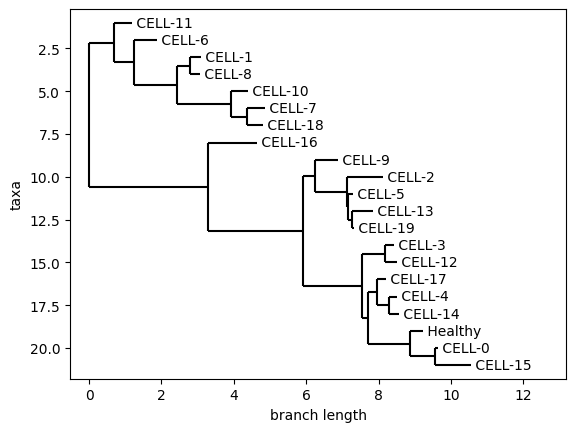

In [78]:
from Bio import Phylo
import io
import matplotlib.pyplot as plt

# Define your tree in Newick format
root = build_best_tree()

# Parse the tree
tree = Phylo.read(io.StringIO(str(root)), "newick")

# Plot the tree
Phylo.draw(tree)
plt.show()

Building tree with likelihood -23323.548681817625
[{'Healthy'}, {'CELL-0'}, {'CELL-1'}, {'CELL-2'}, {'CELL-3'}, {'CELL-4'}, {'CELL-5'}, {'CELL-6'}, {'CELL-7'}, {'CELL-8'}, {'CELL-9'}, {'CELL-10'}, {'CELL-11'}, {'CELL-12'}, {'CELL-13'}, {'CELL-14'}, {'CELL-15'}, {'CELL-16'}, {'CELL-17'}, {'CELL-18'}, {'CELL-19'}, {'CELL-13', 'CELL-19'}, {'CELL-13', 'CELL-19', 'CELL-5'}, {'CELL-8', 'CELL-1'}, {'CELL-18', 'CELL-7'}, {'CELL-2', 'CELL-13', 'CELL-19', 'CELL-5'}, {'CELL-18', 'CELL-10', 'CELL-7'}, {'CELL-15', 'CELL-0'}, {'CELL-14', 'CELL-4'}, {'CELL-14', 'CELL-4', 'CELL-17'}, {'CELL-3', 'CELL-12'}, {'CELL-7', 'CELL-18', 'CELL-10', 'CELL-8', 'CELL-1'}, {'CELL-2', 'CELL-13', 'CELL-5', 'CELL-19', 'CELL-9'}, {'CELL-7', 'CELL-6', 'CELL-18', 'CELL-10', 'CELL-8', 'CELL-1'}, {'Healthy', 'CELL-15', 'CELL-0'}, {'CELL-14', 'CELL-4', 'CELL-17', 'CELL-15', 'Healthy', 'CELL-0'}, {'CELL-14', 'CELL-4', 'CELL-3', 'CELL-15', 'Healthy', 'CELL-12', 'CELL-0', 'CELL-17'}, {'CELL-14', 'CELL-4', 'CELL-3', 'CELL-15', 

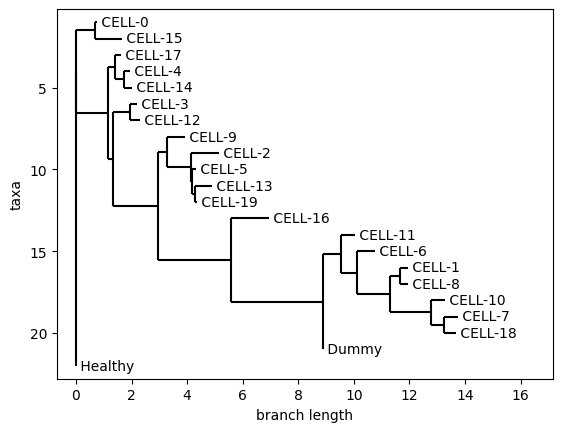

In [79]:
root = build_best_tree()
healthy = root.find("Healthy")

if not healthy:
    raise Exception("No healthy cell found")

new_root = re_root_tree(healthy.parent, healthy)
new_root = Inner(new_root, healthy, 0, 0)

# Parse the tree
tree = Phylo.read(io.StringIO(str(new_root)), "newick")

# Plot the tree
Phylo.draw(tree)
plt.show()

### Reference generated by Cellphy


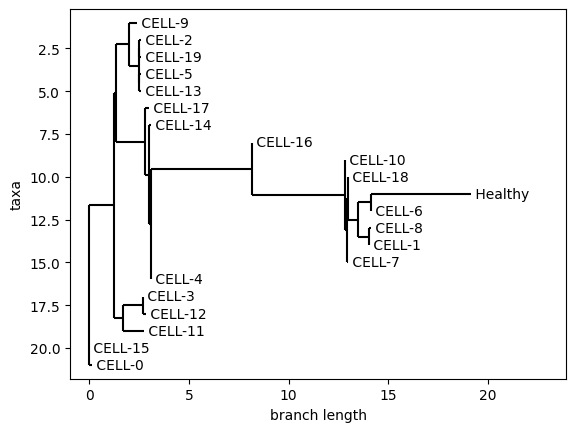

In [80]:
cellphy_tree = """
((((CELL-9:0.389172,((CELL-2:0.062899,CELL-19:0.082929):0.002603,(CELL-5:0.064502,CELL-13:0.070217):0.003462):0.503645):0.663001,(CELL-17:0.204539,(CELL-14:0.090950,((CELL-16:0.000001,(CELL-10:0.000001,((CELL-18:0.011663,((Healthy:5.013858,CELL-6:0.000001):0.647667,(CELL-8:0.105011,CELL-1:0.012577):0.549322):0.499940):0.036010,CELL-7:0.039538):0.095817):4.654443):5.083773,CELL-4:0.000001):0.087044):0.199825):1.466293):0.091043,((CELL-3:0.000356,CELL-12:0.146158):1.007327,CELL-11:1.048311):0.462578):1.256209,CELL-15:0.000001,CELL-0:0.123255);
"""

Phylo.draw(
    Phylo.read(
        io.StringIO(cellphy_tree),
        "newick",
    )
)
plt.show()